In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os
import random
import shutil

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-classification/versions/4",
                   input_shape=(224, 224,3))
])

In [ ]:
!mkdir ~/.kaggle

# !cp 'kaggle.json' ~/.kaggle
!cp '/content/drive/MyDrive/hacktiv8/kaggle.json' ~/.kaggle

!ls ~/.kaggle

kaggle.json


In [ ]:
#download dataset
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

 96% 103M/107M [00:00<00:00, 171MB/s] 
100% 107M/107M [00:00<00:00, 162MB/s]


In [ ]:
!unzip -q /content/brian-tumor-dataset.zip -d images

In [ ]:
os.listdir('/content/images/Brain Tumor Data Set/Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

In [ ]:

# Define paths
source_dirs = ['/content/images/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
               '/content/images/Brain Tumor Data Set/Brain Tumor Data Set/Healthy']

train_dir = '/content/images/data/train'
test_dir = '/content/images/data/test'
validation_dir = '/content/images/data/validation_data'

# Create train, test, and validation directories if they don't exist
for dir_path in [train_dir, test_dir, validation_dir]:
    os.makedirs(os.path.join(dir_path, 'Brain Tumor'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'Healthy'), exist_ok=True)

# Split ratio for train, test, and validation
split_ratio = {'train': 0.7, 'test': 0.2, 'validation': 0.1}

# Function to move files
def move_files(source_dir, dest_dir, files):
    for file in files:
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir, file))

# Move files into train, test, and validation directories
for source_dir in source_dirs:
    files = os.listdir(source_dir)
    random.shuffle(files)  # Shuffle files to randomize the order

    # Calculate split points
    train_split = int(split_ratio['train'] * len(files))
    test_split = int(split_ratio['test'] * len(files))

    # Split files into train, test, and validation sets
    train_files = files[:train_split]
    test_files = files[train_split:train_split + test_split]
    validation_files = files[train_split + test_split:]

    # Move files to respective directories
    move_files(source_dir, os.path.join(train_dir, os.path.basename(source_dir)), train_files)
    move_files(source_dir, os.path.join(test_dir, os.path.basename(source_dir)), test_files)
    move_files(source_dir, os.path.join(validation_dir, os.path.basename(source_dir)), validation_files)

print("Data split completed successfully!")


Data split completed successfully!


In [ ]:
for dirpath, dirnames, filenames in os.walk("images/data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 3 directories and 0 files in 'images/data'.
There are 2 directories and 0 files in 'images/data/validation_data'.
There are 0 directories and 252 files in 'images/data/validation_data/Brain Tumor'.
There are 0 directories and 210 files in 'images/data/validation_data/Healthy'.
There are 2 directories and 0 files in 'images/data/test'.
There are 0 directories and 502 files in 'images/data/test/Brain Tumor'.
There are 0 directories and 417 files in 'images/data/test/Healthy'.
There are 2 directories and 0 files in 'images/data/train'.
There are 0 directories and 1759 files in 'images/data/train/Brain Tumor'.
There are 0 directories and 1460 files in 'images/data/train/Healthy'.


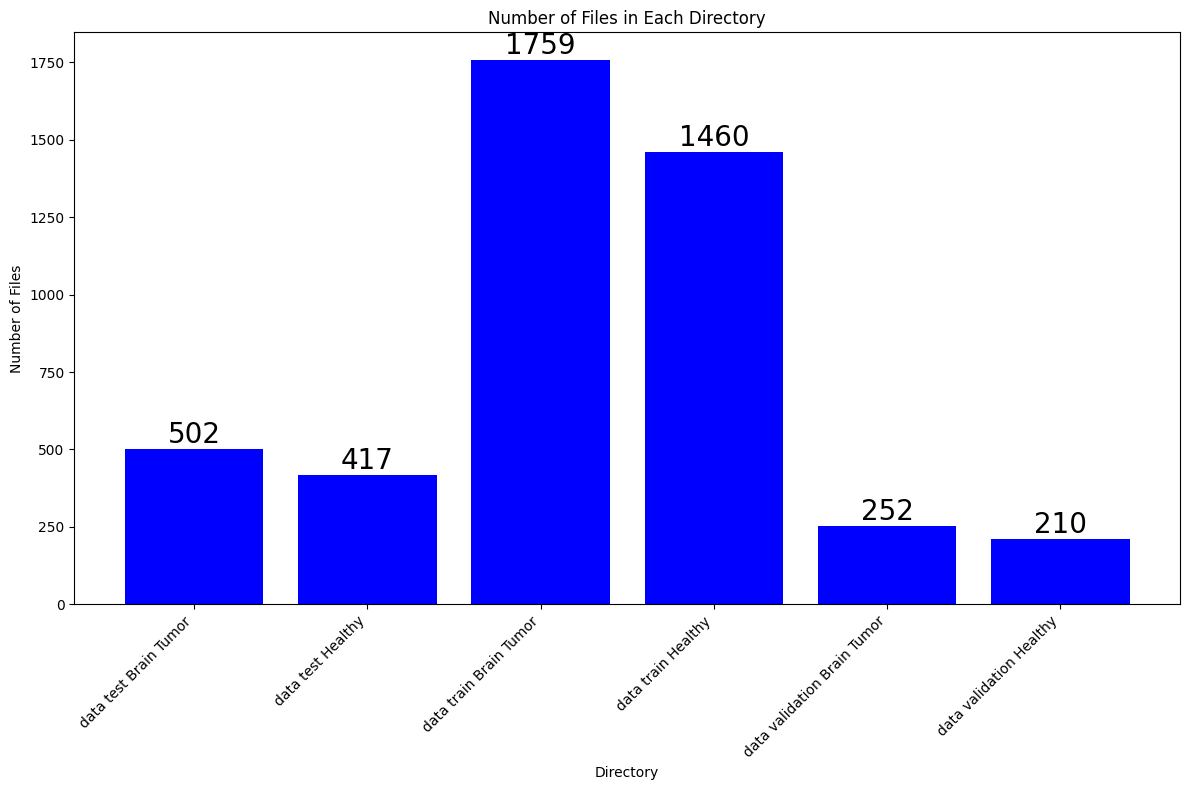

In [ ]:
# Define the directory path
directory_path = "images/data"

# Lists to store directory names and corresponding image counts
directories_test, directories_train, directories_val = [],[],[]
image_counts_test, image_counts_train, image_counts_val = [],[],[]

# Iterate over directories and count images
for dirpath, dirnames, filenames in os.walk(directory_path):
    if 'test' in dirpath:
        directory_name = os.path.basename(dirpath)
        directories_test.append('data test '+ directory_name )
        image_counts_test.append(len(filenames))
    elif 'train' in dirpath:
        directory_name = os.path.basename(dirpath)
        directories_train.append('data train '+ directory_name )
        image_counts_train.append(len(filenames))
    elif 'validation' in dirpath:
        directory_name = os.path.basename(dirpath)
        directories_val.append('data validation '+ directory_name )
        image_counts_val.append(len(filenames))


directories_test.pop(0)
image_counts_test.pop(0)
directories_train.pop(0)
image_counts_train.pop(0)
directories_val.pop(0)
image_counts_val.pop(0)

directories = directories_test + directories_train + directories_val
image_counts = image_counts_test + image_counts_train + image_counts_val


# Create bar plot
plt.figure(figsize=(12, 8))
bars = plt.bar(directories, image_counts, color='blue')
plt.xlabel('Directory')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Directory')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), ha='center', va='bottom',fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=40,      # Rotation angle in degrees (e.g., 40)
    width_shift_range=0.2,  # Fraction of total width (e.g., 0.2)
    height_shift_range=0.2, # Fraction of total height (e.g., 0.2)
    shear_range=0.2,        # Shear intensity (e.g., 0.2)
    zoom_range=0.2,         # Range for random zoom (e.g., 0.2)
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest' )    # Strategy for filling in newly created pixels (e.g., 'nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory('/content/images/data/train',
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory('/content/images/data/validation_data',
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

test_data = test_datagen.flow_from_directory('/content/images/data/test',
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)



Found 3219 images belonging to 2 classes.
Found 462 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


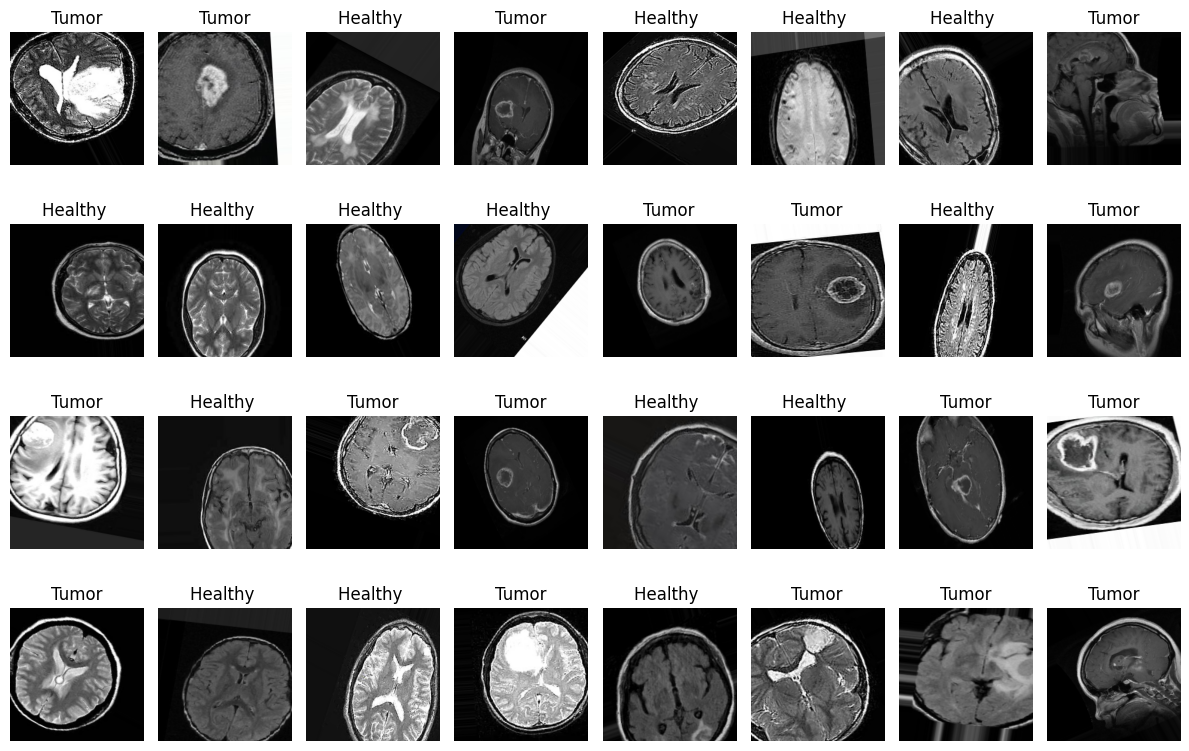

In [ ]:
# Get a batch of images and labels
images, labels = train_data.next()

# Display the images
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.flatten()

for img, ax, label in zip(images, axes, labels):
    ax.imshow(img)
    if label == 0 :
      ax.set_title(f"Tumor")
      ax.axis('off')
    else :
      ax.set_title(f"Healthy ")
      ax.axis('off')

plt.tight_layout()
plt.show()


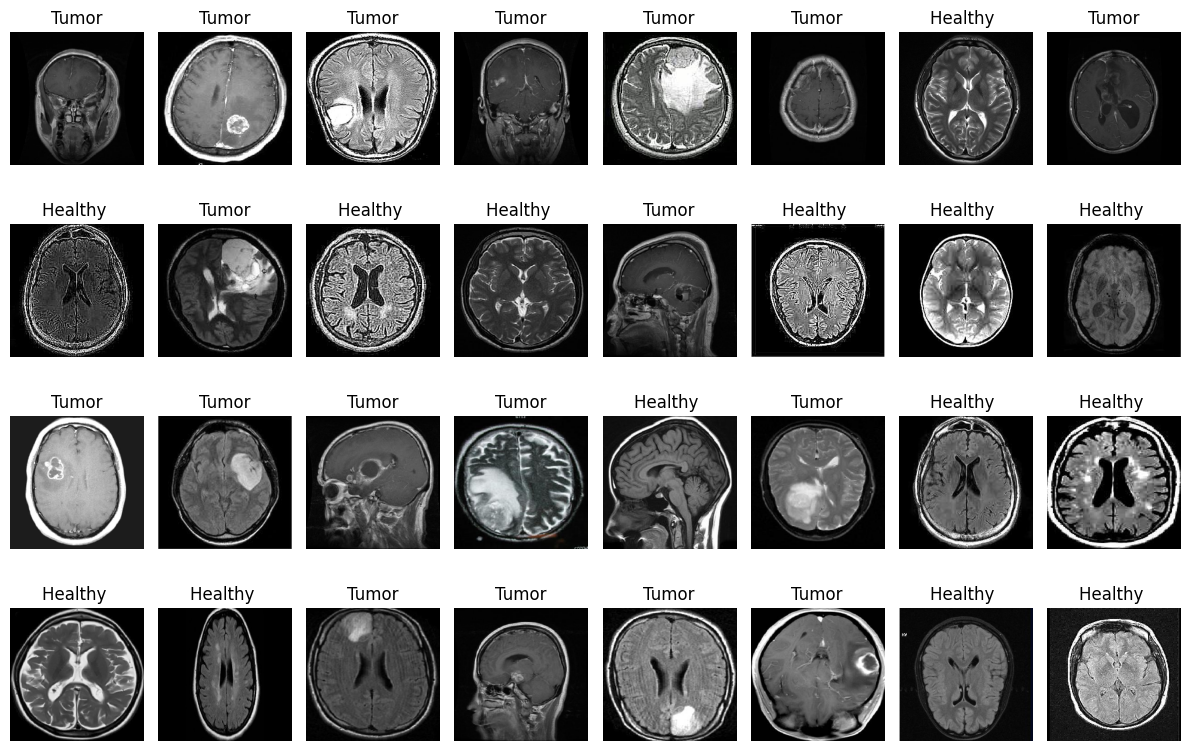

In [ ]:
# Get a batch of images and labels
images, labels = valid_data.next()

# Display the images
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.flatten()

for img, ax, label in zip(images, axes, labels):
    ax.imshow(img)
    if label == 0 :
      ax.set_title(f"Tumor")
      ax.axis('off')
    else :
      ax.set_title(f"Healthy ")
      ax.axis('off')

plt.tight_layout()
plt.show()


https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"


In [ ]:
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=True)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,

  tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience= 3,restore_best_weights=True),
    ModelCheckpoint('bestmodel.keras', monitor='val_loss', save_best_only=True)
]

In [ ]:
tf.random.set_seed(42)
model.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  metrics=[tf.keras.metrics.Recall()])

history = model.fit(train_data,batch_size = 32, epochs=15,
          validation_data = valid_data, callbacks = callbacks )


Epoch 1/15
101/101 [==============================] - 636s 6s/step - loss: 0.3708 - recall: 0.8877 - val_loss: 0.6526 - val_recall: 0.9762
Epoch 2/15
101/101 [==============================] - 630s 6s/step - loss: 0.2395 - recall: 0.9425 - val_loss: 0.2977 - val_recall: 0.9286
Epoch 3/15
101/101 [==============================] - 607s 6s/step - loss: 0.2213 - recall: 0.9603 - val_loss: 0.1836 - val_recall: 0.9810
Epoch 4/15
101/101 [==============================] - 607s 6s/step - loss: 0.2185 - recall: 0.9555 - val_loss: 0.1703 - val_recall: 0.9476
Epoch 5/15
101/101 [==============================] - 604s 6s/step - loss: 0.1866 - recall: 0.9637 - val_loss: 0.2544 - val_recall: 0.9286
Epoch 6/15
101/101 [==============================] - 593s 6s/step - loss: 0.1837 - recall: 0.9630 - val_loss: 0.4981 - val_recall: 0.9857
Epoch 7/15
101/101 [==============================] - 593s 6s/step - loss: 0.1970 - recall: 0.9603 - val_loss: 0.1682 - val_recall: 0.9571
Epoch 8/15
101/101 [=======

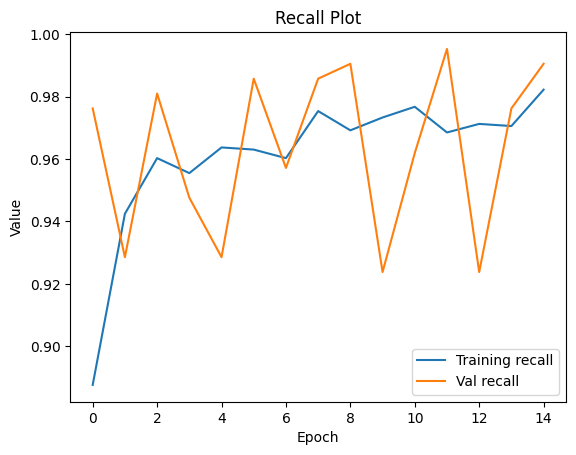

In [ ]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Val recall')
plt.title('Recall Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

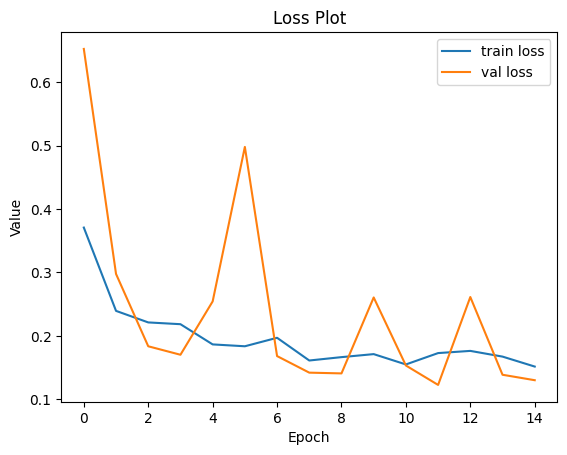

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.evaluate(valid_data)

15/15 [==============================] - 13s 778ms/step - loss: 0.1301 - recall: 0.9905


[0.13013319671154022, 0.9904761910438538]

In [ ]:
y_pred = model.predict(test_data)

29/29 [==============================] - 27s 906ms/step


------------------------------ Test ------------------------------
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       502
           1       0.48      0.49      0.48       417

    accuracy                           0.53       919
   macro avg       0.52      0.52      0.52       919
weighted avg       0.53      0.53      0.53       919



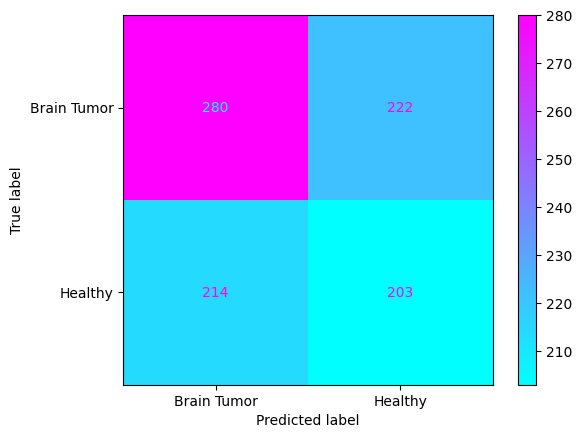

In [ ]:
prediction = np.where(y_pred > 0.5,1,0)

print('-'*30,'Test','-'*30)
print(classification_report(test_data.labels, prediction))

conf_matrix = confusion_matrix(test_data.labels, prediction)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=list(test_data.class_indices.keys()))
display.plot(cmap='cool')
plt.show()

In [ ]:
y_pred_train = model.predict(train_data)

101/101 [==============================] - 137s 1s/step


------------------------------ Train ------------------------------
              precision    recall  f1-score   support

           0       0.54      0.53      0.54      1759
           1       0.45      0.46      0.45      1460

    accuracy                           0.50      3219
   macro avg       0.50      0.50      0.50      3219
weighted avg       0.50      0.50      0.50      3219



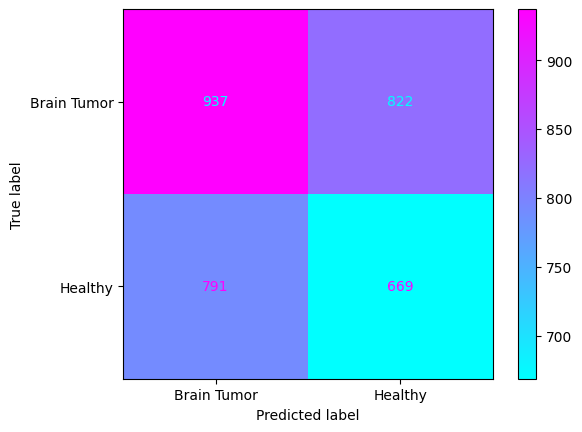

In [ ]:
prediction_train = np.where(y_pred_train > 0.5,1,0)

print('-'*30,'Train','-'*30)
print(classification_report(train_data.labels, prediction_train))

conf_matrix = confusion_matrix(train_data.labels, prediction_train)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=list(train_data.class_indices.keys()))
display.plot(cmap='cool')
plt.show()

In [ ]:
model.save('my_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
